In [6]:
#Import necessary Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
%matplotlib inline

In [7]:
#checking my tensorflow version
tf.__version__

'2.8.0'

In [9]:
#Import the data and remove rows containing NAN values
ds = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')
ds=ds. iloc[::-1]
ds.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [10]:
ds.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35


In [11]:
#Data Preprocessing
ds.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [12]:
ds.shape

(2035, 8)

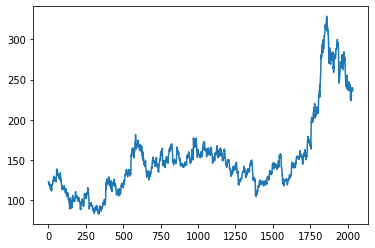

In [13]:
ds_high=ds.reset_index()['High']
plt.plot(ds_high)

In [14]:
#Since LSTM are sensitive to the scale of the data, so we apply MinMax Scaler to transform our values between 0 and 1

scaler = MinMaxScaler(feature_range = (0,1))
ds_high = scaler.fit_transform(np.array(ds_high).reshape(-1,1))

In [15]:
ds_high.shape

(2035, 1)

In [16]:
ds_high

array([[0.16344786],
       [0.15938199],
       [0.15917869],
       ...,
       [0.6391543 ],
       [0.62614353],
       [0.62268754]])

In [17]:
#Split the data into train and test split
training_size = int(len(ds_high) * 0.75)
test_size = len(ds_high) - training_size
train_data, test_data = ds_high[0:training_size,:], ds_high[training_size:len(ds_high),:1]

In [18]:
training_size,test_size

(1526, 509)

In [19]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

    


In [20]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [21]:
#Reshape the input to be [samples, time steps, features] which is the requirement of LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)




In [22]:
print(x_train.shape), print(y_train.shape)

(1425, 100, 1)
(1425,)


(None, None)

In [23]:
print(x_test.shape), print(y_test.shape)

(408, 100, 1)
(408,)


(None, None)

In [24]:
#Create the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')




In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
23/23 [==============================] - 17s 404ms/step - loss: 0.0112 - val_loss: 0.0447
Epoch 2/100
23/23 [==============================] - 8s 368ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 3/100
23/23 [==============================] - 8s 366ms/step - loss: 8.4228e-04 - val_loss: 0.0032
Epoch 4/100
23/23 [==============================] - 9s 408ms/step - loss: 8.1739e-04 - val_loss: 0.0033
Epoch 5/100
23/23 [==============================] - 10s 429ms/step - loss: 7.5794e-04 - val_loss: 0.0032
Epoch 6/100
23/23 [==============================] - 9s 366ms/step - loss: 7.2892e-04 - val_loss: 0.0037
Epoch 7/100
23/23 [==============================] - 8s 364ms/step - loss: 6.9153e-04 - val_loss: 0.0033
Epoch 8/100
23/23 [==============================] - 8s 365ms/step - loss: 6.8887e-04 - val_loss: 0.0025
Epoch 9/100
23/23 [==============================] - 8s 366ms/step - loss: 6.4810e-04 - val_loss: 0.0037
Epoch 10/100
23/23 [==============================] - 8s 367m

In [27]:
#Lets predict and check performance metrics
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [28]:
#Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [29]:
#Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train, train_predict))

135.65090069211303

In [30]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

221.7288895107014

In [31]:
#Plotting

#Shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(ds_high)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shift test prediction for plotting
testPredictPlot = np.empty_like(ds_high)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(ds_high) - 1, :] = test_predict



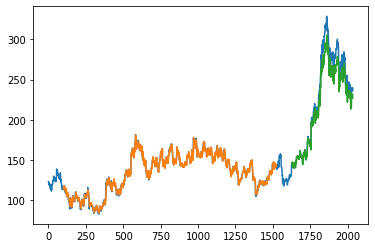

Green indicates the Predicted Data
Blue indicates the Complete Data
Orange indicates the Train Data


In [32]:
#Plot baseline and predictions
plt.plot(scaler.inverse_transform(ds_high))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

print("Green indicates the Predicted Data")
print("Blue indicates the Complete Data")
print("Orange indicates the Train Data")

In [33]:
#Predict the next 28 days Stock Price
len(test_data), x_test.shape

(509, (408, 100, 1))

In [34]:
x_input = test_data[409:].reshape(1,-1)
x_input.shape

(1, 100)

In [35]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output=[]
n_steps=100
nextNumberOfDays = 28
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.5849866]
101
1 day input [0.86013417 0.85464525 0.84448059 0.8072779  0.71843871 0.66192316
 0.67696686 0.67554381 0.67310429 0.68428542 0.68936776 0.70217524
 0.71803212 0.72941655 0.73144948 0.74486684 0.76926205 0.75991055
 0.74242732 0.73958122 0.74771295 0.75991055 0.7584875  0.76621264
 0.75462492 0.76316324 0.79670665 0.80585485 0.7889815  0.78003659
 0.73978451 0.73002643 0.73490547 0.74872942 0.75991055 0.75462492
 0.75401504 0.76174019 0.7737345  0.82008538 0.80585485 0.81154706
 0.77434438 0.78633869 0.79284407 0.78328929 0.77109169 0.74385038
 0.71193332 0.68733482 0.67818662 0.65257166 0.64301687 0.65643423
 0.67656028 0.67371417 0.65114861 0.65521447 0.66761537 0.67838992
 0.69993901 0.63122586 0.63508843 0.64098394 0.64545639 0.64118723
 0.63854442 0.63081927 0.62472047 0.6330555  0.64728603 0.6574507
 0.66761537 0.66720878 0.64159382 0.62776987 0.63651149 0.63630819
 0.62980281 0.62817646 0.63813783 0.65358813 0.63183574 0.57653995
 0.57816629 0.57613336 0.61943484 0

In [36]:
day_new = np.arange(1,101)
day_pred = np.arange(101,129)

In [37]:
day_new.shape

(100,)

In [38]:
day_pred.shape


(28,)

In [39]:
ds3 = ds_high.tolist()
ds3.extend(lst_output)

len(ds_high)

2035

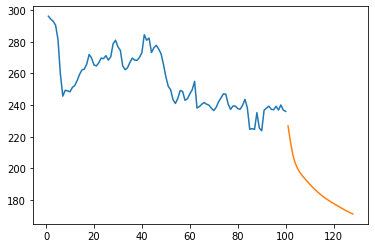

In [40]:
plt.plot(day_new, scaler.inverse_transform(ds_high[1935:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

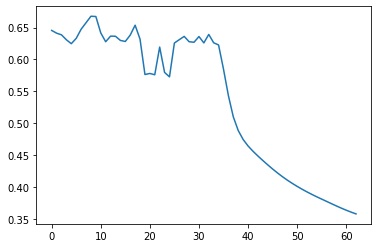

In [41]:
ds3=ds_high.tolist()
ds3.extend(lst_output)
plt.plot(ds3[2000:])

In [42]:
ds3=scaler.inverse_transform(ds3).tolist()

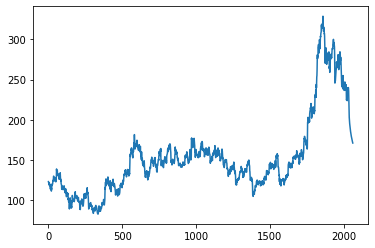

In [43]:
plt.plot(ds3)